<a href="https://colab.research.google.com/github/pablo-arantes/ParametrizANI/blob/main/ParametrizANI_RotProf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ParametrizANI: Fast, Accurate and Free Parametrization for Small Molecules**

# Rotational Profile - Python Version

This Jupyter notebook is designed to fit an empirical energy profile to a reference profile, which can be obtained experimentally, through quantum-mechanical (QM) methods, or using TorchANI - deep learning models for potential energy surfaces. We developed a Python version of the [Rotational Profiler code](https://rotprof.lncc.br/index.php) developed by Rusu *et al.* This tool offers an analytical algorithm for computing classical torsional dihedral parameters, by fitting an empirical energy profile to a reference one acquired either experimentally or via quantum-mechanical methods. The profiles generated are compatible with functional forms in popular biomolecular force fields like GROMOS, AMBER, OPLS, and CHARMM. To determine the best-fitting sets of parameters, a linear least-squares regression method is employed.

The user can choose the most appropriate fitting to be used, which should be added to the classical model, so that a similar description of relative conformational classical energies can be obtained. It is worth noting that Rotational Profiler does not constrain the phase shifts, δ, to 0°/180°. As comprehensively discussed and previously demonstrated, allowing the use of asymmetrical δ provides a closer fit to the reference curve at expense of portability, as associated potentials may not be transferable between stereoisomers.

---

 **This notebook is NOT a standard protocol for parametrization!** It is just simple pipeline illustrating the fit process.

---


**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/ParametrizANI/issues

**Acknowledgments**
- We would like to express our gratitude to the team behind [Rotational Profiler](https://rotprof.lncc.br/index.php), especially [Victor H. Rusu](https://www.linkedin.com/in/victor-holanda-rusu-463766b2/) and [Roberto D. Lins](https://www.linkedin.com/in/roberto-lins-49477710/), for their dedication in developing the code and making it permanently available to the community.

- We would like to thank the OpenMM team for developing an excellent and open source engine.

- We would like to thank the [Psi4](https://psicode.org/) team for developing an excellent and open source suite of ab initio quantum chemistry.

- We would like to thank the [Roitberg](https://roitberg.chem.ufl.edu/) team for developing the fantastic [TorchANI](https://github.com/aiqm/torchani).

- We would like to thank the [Olexandr Isayev](https://twitter.com/olexandr) team for developing the fantastic [AIMNet2](https://github.com/isayevlab/AIMNet2).

- We would like to thank the [Xavier Barril](http://www.ub.edu/bl/) team for their protocol on dihedrals parametrization.

- We would like to thank [iwatobipen](https://twitter.com/iwatobipen) for his fantastic [blog](https://iwatobipen.wordpress.com/) on chemoinformatics.

- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- Finally, we would like to thank [Making it rain](https://github.com/pablo-arantes/making-it-rain) team, **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)), for their amazing work.

- For related notebooks see: https://github.com/pablo-arantes/ParametrizANI


In [1]:
#@title **Import dependencies, load classes and functions**
# install dependencies

import argparse
import logging
import os
import numpy as np

# FileLogger class
class FileLogger:
    def __init__(self, file_name, mode='a'):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)
        self.set_up_file_logger(mode)

    def set_up_file_logger(self, mode):
        file_handler = logging.FileHandler(self.file_name, mode=mode)
        formatter = logging.Formatter('[%(levelname)s] %(message)s')
        file_handler.setFormatter(formatter)
        self.logger.addHandler(file_handler)

    def set_level(self, level):
        self.logger.setLevel(level)

    def debug(self, message, *args):
        self.logger.debug(message, *args)

    def info(self, message, *args):
        self.logger.info(message, *args)

    def warning(self, message, *args):
        self.logger.warning(message, *args)

    def error(self, message, *args):
        self.logger.error(message, *args)


# DataFileReader class
class DataFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)

    def read_file(self):
        phis = []
        enes = []
        try:
            with open(self.file_name, 'r') as file:
                for line in file:
                    if line.startswith('#') or not line.strip():
                        continue  # Skip commented or empty lines
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            phi = float(parts[0])
                            ene = float(parts[1])
                            phis.append(phi)
                            enes.append(ene)
                            self.logger.debug("data line: %s", line.strip())
                        except ValueError as e:
                            self.logger.error("Invalid data format: %s", e)
            if len(phis) == 0:
                self.logger.error("No data found inside data file %s", self.file_name)
                return [], []
            return phis, enes
        except IOError as e:
            self.logger.error("Error reading file %s: %s", self.file_name, e)
            return [], []

# IniFileReader class
class IniFileReader:
    def __init__(self, file_name):
        self.file_name = file_name
        self.logger = logging.getLogger(__name__)

    def read_file(self, N):
        is_active = [0] * N
        pshift = [0] * N
        multiplicities = [0] * N
        phase_offsets = [0.0] * N

        try:
            with open(self.file_name, 'r') as file:
                nlines = 0
                for line in file:
                    if line.startswith('#') or not line.strip():
                        continue  # Skip commented or empty lines
                    parts = line.split()
                    if len(parts) >= 4:
                        try:
                            multi = int(parts[0])
                            phi_shift = int(parts[1])
                            phase_offset = float(parts[2])
                            active = int(parts[3])

                            if nlines < N:
                                multiplicities[nlines] = multi
                                pshift[nlines] = phi_shift
                                phase_offsets[nlines] = phase_offset
                                is_active[nlines] = active
                                nlines += 1
                            else:
                                break  # Stop reading if N lines are read

                            self.logger.debug("ini line: %s", line.strip())
                        except ValueError as e:
                            self.logger.error("Invalid data format: %s", e)
            if nlines != N:
                self.logger.error(f"Expected {N} lines in file, found {nlines}")
                return [], [], [], []

            num_active_coeffs = sum(is_active)
            if num_active_coeffs < 1:
                self.logger.error("There are no active coefficients")
                return [], [], [], []

            return multiplicities, pshift, phase_offsets, is_active
        except IOError as e:
            self.logger.error("Error reading file %s: %s", self.file_name, e)
            return [], [], [], []


pi = 3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679
SMALL_REAL = 1.0E-8

def m_prod(a, b, ndim):
    c = np.zeros((ndim, ndim))
    a = a.reshape(ndim, ndim)
    b = b.reshape(ndim, ndim)
    for i in range(ndim):
        for j in range(ndim):
            sum = 0.0
            for k in range(ndim):
                sum += a[k, i] * b[j, k]
            c[j, i] = sum
    return c.ravel()

def mv_prod(a, u, ndim):
    v = np.zeros(ndim)
    for i in range(ndim):
        sum = 0.0
        for j in range(ndim):
            sum += a[j * ndim + i] * u[j]
        v[i] = sum
    return v

def m_gjpdiag(a, ndim):
    d = 1.0
    l = np.zeros(ndim, dtype=int)
    m = np.zeros(ndim, dtype=int)

    for k in range(ndim):
        l[k] = m[k] = k
        biga = a[k * ndim + k]

        # Search for largest element
        for j in range(k, ndim):
            for i in range(k, ndim):
                hold = a[ndim * j + i]
                if abs(biga) < abs(hold):
                    biga = hold
                    l[k] = i
                    m[k] = j

        # Interchange rows
        if l[k] > k:
            for i in range(ndim):
                hold = -a[k * ndim + i]
                a[k * ndim + i] = a[l[k] * ndim + i]
                a[l[k] * ndim + i] = hold

        # Interchange columns
        if m[k] > k:
            for i in range(ndim):
                hold = -a[i * ndim + k]
                a[i * ndim + k] = a[i * ndim + m[k]]
                a[i * ndim + m[k]] = hold

        # Divide column by minus pivot
        if biga > -SMALL_REAL and biga < SMALL_REAL:
            return a, 0.0  # Matrix is singular

        for i in range(ndim):
            if i != k:
                a[i * ndim + k] /= -biga

        # Reduce matrix
        for i in range(ndim):
            if i != k:
                for j in range(ndim):
                    if j != k:
                        a[i * ndim + j] += a[i * ndim + k] * a[k * ndim + j]

        # Divide row by pivot
        for j in range(ndim):
            if j != k:
                a[k * ndim + j] /= biga

        # Product of pivots
        d *= biga

        # Replace pivot by reciprocal
        a[k * ndim + k] = 1.0 / biga

    # Final row and column interchange
    for k in range(ndim - 2, -1, -1):
        if l[k] != k:
            for j in range(ndim):
                hold = a[j * ndim + k]
                a[j * ndim + k] = -a[j * ndim + l[k]]
                a[j * ndim + l[k]] = hold

        if m[k] != k:
            for i in range(ndim):
                hold = a[k * ndim + i]
                a[k * ndim + i] = -a[m[k] * ndim + i]
                a[m[k] * ndim + i] = hold

    return a, d

def fit_dihedral(num_active_coeffs, phis, ref_energies, mm_energies, weights, mult, pshift, phase_offset, is_active):
    nPTS = len(phis)
    N = len(is_active)
    a = np.zeros((N * N))
    atmp = np.zeros((N * N))
    atmp2 = np.zeros((N * N))
    b = np.zeros(N)
    c = np.zeros(N)
    cmod = np.zeros(N)
    fittedcurve = np.zeros(nPTS)
    fittedcoeff = np.zeros(N)
    lwrk = np.zeros(N, dtype=int)
    mwrk = np.zeros(N, dtype=int)

    i = 0
    for k in range(N):
        if is_active[k]:
            i += 1
            j = 0
            for l in range(N):
                if is_active[l]:
                    j += 1
                    sum = 0.0
                    for m in range(nPTS):
                        ph1 = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                        ph2 = (phis[m] - phase_offset[l]) / 360.0 * 2.0 * pi
                        sum += weights[m] * (1.0 + pshift[k] * np.cos(mult[k] * ph1)) * \
                               (1.0 + pshift[l] * np.cos(mult[l] * ph2))
                    a[num_active_coeffs * (i - 1) + (j - 1)] = sum

            sum = 0.0
            for m in range(nPTS):
                ph = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                sum += weights[m] * (1.0 + pshift[k] * np.cos(mult[k] * ph)) * (ref_energies[m] - mm_energies[m])
            b[i - 1] = sum

    for i in range(num_active_coeffs):
        for j in range(num_active_coeffs):
            atmp[N * i + j] = a[num_active_coeffs * i + j]

    # a, det = m_gjpdiag(a, num_active_coeffs)
    # if det == 0.0:
    #     print("Matrix inversion error, det = 0")
    #     return None, None

    a, det = m_gjpdiag(a, num_active_coeffs)
    # if det == 0.0:
    #     print("Warning: Singular matrix encountered. Using pseudo-inverse.")
    #     coeffs = np.dot(np.linalg.pinv(a.reshape(num_active_coeffs, num_active_coeffs)), b)
    # else:
    atmp2 = m_prod(atmp, a, num_active_coeffs)
    coeffs = mv_prod(a, b, num_active_coeffs)
    atmp2 = m_prod(atmp, a, num_active_coeffs)
    c = mv_prod(a, b, num_active_coeffs)
    cmod = mv_prod(a, b, num_active_coeffs)

    # Additional logic for modifying cmod...
    # ...

    for m in range(num_active_coeffs):
        fittedcoeff[m] = c[m]

    for m in range(nPTS):
        sum1 = 0.0
        sum2 = 0.0
        i = 0
        for k in range(N):
            if is_active[k]:
                i += 1
                ph = (phis[m] - phase_offset[k]) / 360.0 * 2.0 * pi
                sum1 += c[i - 1] * (1.0 + pshift[k] * np.cos(mult[k] * ph))
                sum2 += cmod[i - 1] * (1.0 + pshift[k] * np.cos(mult[k] * ph))
        fittedcurve[m] = mm_energies[m] + sum1

    return fittedcurve, fittedcoeff

# Function to create directories
def create_dir(path):
    """Create a directory if it does not exist."""
    try:
        os.makedirs(path, exist_ok=True)
        return True
    except OSError as e:
        if e.errno != errno.EEXIST:
            print(f"Error creating directory {path}: {e}")
            return False
        return True  # Directory already exists

In [6]:
#@title **Upload the Required Files**

#@markdown Please run this cell to upload the required files (reference energy profile and empirical energy profile).

#@markdown **Start by uploading your reference energy file, followed by the empirical energy file (force field profile).**

#@markdown 📄 You can find an example of the reference energy file format [**here**](https://github.com/pablo-arantes/ParametrizANI/raw/main/examples/qm.dat).

#@markdown 📄 You can find an example of the empirical energy file format [**here**](https://github.com/pablo-arantes/ParametrizANI/raw/main/examples/mm.dat).
from google.colab import files
import sys

uploaded = files.upload()
for fn in uploaded.keys():
  os.rename(fn, "QM.dat")

uploaded = files.upload()
for fn in uploaded.keys():
  os.rename(fn, "MM.dat")

Saving qm.dat to qm.dat


Saving mm.dat to mm.dat


In [7]:
#@title **Fit an empirical energy profile to a reference profile**:

#@markdown In this cell, we will fit an empirical energy profile to a reference profile using a python version of Rotational Profiler.

Reference_profile = 'QM.dat'
Force_field_profile = 'MM.dat'


import logging
import os
import numpy as np

def calculate_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) ** 2))

# Setting parameters directly (these would typically be command line arguments)
basedir = './'  # Directory to save the output files
logfile_name = os.path.join(basedir, 'output.log')  # Output filename
# ini_filename = 'inifile2.dat'  # Configuration file
ref_filename = Reference_profile # File with reference profile
mm_filename = Force_field_profile  # File with MM profile

# Define your parameters here
mult = [0, 1, 1, 2, 2, 3, 6]
pshift = [1, 1, 1, 1, 1, 1, 1]
phase_offsets = [0, 0, 120, 0, 120, 0, 0]
is_active = [1, 1, 1, 1, 1, 1, 1]  # Example: Activate coefficients at lines 0, 3, and 5

run_sequences = [
    [3],
    [0, 3],
    [0, 3, 5],
    [0, 3, 5, 6],
    [0, 1, 3, 5, 6],
    [0, 1, 2, 3, 5, 6],
    [0, 1, 2, 3, 4, 5, 6]
]


# Setup logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# FileLogger setup and directory creation
if not create_dir(basedir):
    logger.error("Unable to create directory %s", basedir)

file_logger = FileLogger(logfile_name)
file_logger.set_level(logging.INFO)

# Calculate the number of active coefficients
num_active_coeffs = sum(is_active)

# Process reference file
ref_reader = DataFileReader(ref_filename)
ref_phis, ref_energies = ref_reader.read_file()

# Process MM file
mm_reader = DataFileReader(mm_filename)
mm_phis, mm_energies = mm_reader.read_file()

# Additional checks and computations
if len(ref_phis) != len(mm_phis):
    logger.error("Number of reference and MM points are not the same")
    # Handle the error as needed

# Adjust reference and MM energy profiles
minimum_ref_value = min(ref_energies)
minimum_mm_value = min(mm_energies)

if abs(minimum_ref_value) > SMALL_REAL:
    ref_energies = [ene - minimum_ref_value for ene in ref_energies]

if abs(minimum_mm_value) > SMALL_REAL:
    mm_energies = [ene - minimum_mm_value for ene in mm_energies]

# Fitting process
weights = [1.0] * len(ref_phis)  # Assuming equal weights for simplicity

fitted_curves = []

for run_index, sequence in enumerate(run_sequences, start=1):
    # Select elements based on the current sequence
    selected_mult = [mult[i] for i in sequence]
    selected_pshift = [pshift[i] for i in sequence]
    selected_phase_offset = [phase_offsets[i] for i in sequence]
    selected_is_active = [1] * len(sequence)  # Activate all selected elements

    NCOEF = sum(selected_is_active)
    NUM_BAS_FCT = sum(selected_is_active)
    SMALL_REAL = 1.0E-8
    N = sum(selected_is_active)

    # Run the fitting function
    fitted_curve, fitted_coeff = fit_dihedral(
        len(sequence),
        ref_phis,
        ref_energies,
        mm_energies,
        weights,
        selected_mult,
        selected_pshift,
        selected_phase_offset,
        selected_is_active
    )
    fitted_curves.append(fitted_curve)
    # Write header line
    print("Multiplicity\tOffset\tCoefficient")

    # Write data
    for mult1, offset, coeff in zip(selected_mult, selected_phase_offset, fitted_coeff):
        print(f"{mult1}\t{offset}\t{coeff}")

    rmse = calculate_rmse(fitted_curve, ref_energies)
    print(f"RMSE for fitted curve {run_index}: {rmse}\n")

    # Save fitted_curve and fitted_coeff to files
    curve_file_name = f"fitted_curve_{run_index}.dat"
    coeff_file_name = f"fitted_coefficients_{run_index}.dat"

    # Save fitted curve
    with open(curve_file_name, 'w') as f_curve:
        for phi, energy in zip(ref_phis, fitted_curve):  # Assuming first fitted curve
            f_curve.write(f"{phi} {energy}\n")

    # Save fitted coefficients
    with open(coeff_file_name, 'w') as f_coeff:
        # Write header line
        f_coeff.write("Multiplicity\tOffset\tCoefficient\n")

        # Write data
        for mult1, offset, coeff in zip(selected_mult, selected_phase_offset, fitted_coeff):
            f_coeff.write(f"{mult1}\t{offset}\t{coeff}\n")

Multiplicity	Offset	Coefficient
2	0	3.2149341363636372
RMSE for fitted curve 1: 15.148514618332827

Multiplicity	Offset	Coefficient
0	0	13.473646277777775
2	0	-13.933342944444446
RMSE for fitted curve 2: 0.9832011436963319

Multiplicity	Offset	Coefficient
0	0	13.31112766666667
2	0	-13.979776833333336
3	0	0.348254166666667
RMSE for fitted curve 3: 0.9503921375803999

Multiplicity	Offset	Coefficient
0	0	13.358177842592589
2	0	-13.96633392592593
3	0	0.3616970740740775
6	0	-0.11426471296296015
RMSE for fitted curve 4: 0.9436546957274673

Multiplicity	Offset	Coefficient
0	0	13.396195618328553
1	0	-0.09775999474962949
2	0	-13.955471704287081
3	0	0.37255929571292046
6	0	-0.10883360214353921
RMSE for fitted curve 5: 0.9410542761330342

Multiplicity	Offset	Coefficient
0	0	13.399402165051121
1	0	-0.09989769256467285
1	120	-0.004275395630078476
2	0	-13.955471704287078
3	0	0.37255929571292046
6	0	-0.10883360214354099
RMSE for fitted curve 6: 0.9410509142864789

Multiplicity	Offset	Coefficient
0	0	

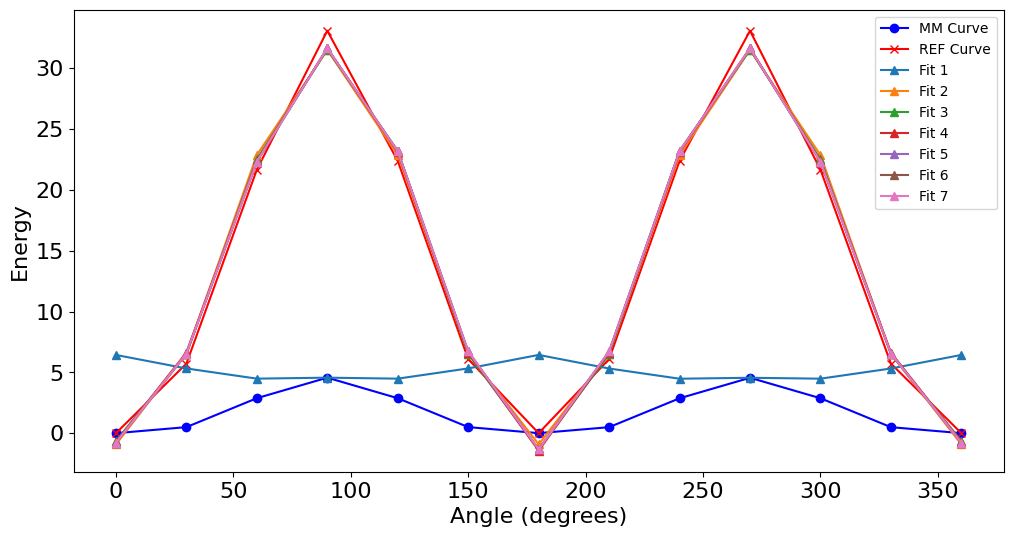

In [8]:
#@title **Check the all the fitted curves**:

#@markdown  The values that are printed in the previous cell, are the values that we should add to the force field to have a correct parametrization of the dihedral.


import matplotlib.pyplot as plt

# Assuming 'phis' contains the angle data for all curves
plt.figure(figsize=(12, 6))

# Plot MM curve
plt.plot(ref_phis, mm_energies, label='MM Curve', color='blue', marker='o')

# Plot REF curve
plt.plot(ref_phis, ref_energies, label='REF Curve', color='red', marker='x')

# Plot each fitted curve
for index, fitted in enumerate(fitted_curves):
    plt.plot(ref_phis, fitted, label=f'Fit {index + 1}', marker='^')

# plt.xticks(range(0, 361, 30))

# plt.xlim([0, 360])


# Adjusting font sizes
# plt.title('MM, REF, and Fitted Curves', fontsize=16)  # Increase title font size
plt.xlabel('Angle (degrees)', fontsize=16)  # Increase X-axis label font size
plt.ylabel('Energy', fontsize=16)  # Increase Y-axis label font size

# Increase X and Y axis tick labels font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

#save png
plt.savefig('fitted_curves.png', format='png', dpi=300)
# Show the plot
plt.show()

In [9]:
#@title **Download your results**
from google.colab import files
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if os.path.exists("fitted_results.zip"):
  os.remove("fitted_results.zip")
else:
  pass

!zip -FSr "fitted_results.zip" *".png" *."dat" >/dev/null 2>&1
files.download('fitted_results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>